# Machine Learning with PyTorch

## Understanding PyTorch

* Tensors and NumPy interfaces
* Autograd
* Using GPUs with `torch.cuda`
* Parallelizing on clusters with `torch.distributed`
* Create a neural network with `torch.nn`

## Tensors and NumPy interfaces

At a first pass, PyTorch tensors are very similar to NumPy arrays.  Both are ways of storing multi-dimensional data efficiently, and much of the same "vectorized" style of operation applies to both. Broadcasting and elementwise operations are similar.  Moreover, many of the same functions and methods exist in both PyTorch and NumPy, and conversion between the two formats is made straightforward by PyTorch.

Where PyTorch tensors go beyond NumPy arrays, and are needed for neural networks are in a couple key areas.  As a not-so-minor matter, tensors can work transparently on GPUs as well as CPUs, and this can often vastly speed up operations.  NumPy does not build in that capability, but a number of projects allow this particular capability to be used outside of PyTorch, in varying ways (see [PyCUDA](https://documen.tician.de/pycuda/array.html), [Numba](https://numba.pydata.org/numba-doc/dev/cuda/index.html), [CuPy](https://cupy.chainer.org/), [MXNet](https://mxnet.incubator.apache.org/versions/master/tutorials/basic/ndarray.html), and probably others).

You *could* use PyTorch simply to work with array computation on GPUs, but what is more likely to bring you here is an equally essential capability that is not present in those other mentioned libraries (by design): Autograd.  By storing the gradients from every operation (where autograd is enabled for any component tensors), PyTorch provides reverse automatic differentiation.  That is to say, it gives you a directed acyclic graph whose leaves are the input tensors and roots are the output tensors.  We explain this more below.

## Autograd

In [1]:
import torch

x = torch.randn(3, 3, requires_grad=True)
print("Random 2-D tensor")
print(x)

# Perform an operation on tensor
y = (x + 7) * 5
print("\nRandom 2-D shifted by 7, multiplied by 5")
print(y)

Random 2-D tensor
tensor([[-0.4707, -0.4236, -0.5479],
        [-3.6637,  0.5018, -0.1823],
        [ 0.6070,  0.0979, -0.5561]], requires_grad=True)

Random 2-D shifted by 7, multiplied by 5
tensor([[32.6463, 32.8821, 32.2606],
        [16.6814, 37.5089, 34.0883],
        [38.0351, 35.4895, 32.2197]], grad_fn=<MulBackward0>)


In [2]:
v = torch.tensor([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]], dtype=torch.float)

# grad_fn is derivative, so offset does not matter to slope
y.grad_fn(v)

(tensor([[ 5., 10., 15.],
         [20., 25., 30.],
         [35., 40., 45.]]), None)

In [3]:
# Perform an additional vectorized operation, then a reduction
z = y * 3
out = z.mean()

print("Multiplied by 3")
print(z)
print("\nMean of values")
print(out)

Multiplied by 3
tensor([[ 97.9388,  98.6462,  96.7817],
        [ 50.0443, 112.5267, 102.2650],
        [114.1052, 106.4686,  96.6592]], grad_fn=<MulBackward0>)

Mean of values
tensor(97.2706, grad_fn=<MeanBackward1>)


In [4]:
grad = out.grad_fn
indent = 1
while True:
    print(" "*indent, "-->", grad)
    if not grad.next_functions:
        break
    grad = grad.next_functions[0][0]
    indent += 1

  --> <MeanBackward1 object at 0x7f27b6399ba8>
   --> <MulBackward0 object at 0x7f27b6399c18>
    --> <MulBackward0 object at 0x7f27b6399c50>
     --> <AddBackward0 object at 0x7f27b6399c88>
      --> <AccumulateGrad object at 0x7f27b6399cc0>


### A low-level neural network

We do not actually *need* autograd—nor the `torch.nn` package—to implement a neural network.  In fact, we can do it pretty easily in NumPy also.  These more advanced capabilities just make things easier.  The next several examples are lightly adapted from [Justin Johnson's discussion](https://github.com/jcjohnson/pytorch-examples), linked in the resources.  A very similar example appears in numerous places, so I am not sure of first source of it.

For this task, we will train a two-layer neural network to learn the relationship between 64 random inputs and 10 random outputs.  In a first version, PyTorch looks almost the same as NumPy. In fact  First setup the problem.

In [5]:
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# The input and output tensors
## The `requires_grad` argument relevant to 2nd example, harmless for 1st
x = torch.randn(N, D_in, dtype=torch.float, requires_grad=False)
y = torch.randn(N, D_out, dtype=torch.float, requires_grad=False)

### Without autograd

The basic array/tensor version:

In [6]:
# Randomly initialize weights
w1 = torch.randn(D_in, H)
w2 = torch.randn(H, D_out)

learning_rate = 1e-6
for t in range(501):
    # Forward pass: compute predicted y
    h = x.mm(w1)             # Spelled `x.dot(w1)` or `x @ w1` in NumPy
    h_relu = h.clamp(min=0)  # Activation function
    y_pred = h_relu.mm(w2)

    # Compute and print loss; loss is a scalar, and is stored in a PyTorch Tensor
    # of shape (); we can get its value as a Python number with loss.item().
    loss = (y_pred - y).pow(2).sum()  # mean squared error
    if not t % 50:
        print("Iteration: %4d - Loss: %0.2e" % (t, loss.data.item()))
        
    # Backprop to compute gradients of w1 and w2 with respect to loss
    ## Notice that name `loss` is not directly used in backprop
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0        # Equivalent to `clamp(min=0)`
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

Iteration:    0 - Loss: 3.08e+07
Iteration:   50 - Loss: 1.36e+04
Iteration:  100 - Loss: 7.66e+02
Iteration:  150 - Loss: 7.86e+01
Iteration:  200 - Loss: 1.01e+01
Iteration:  250 - Loss: 1.45e+00
Iteration:  300 - Loss: 2.16e-01
Iteration:  350 - Loss: 3.31e-02
Iteration:  400 - Loss: 5.44e-03
Iteration:  450 - Loss: 1.12e-03
Iteration:  500 - Loss: 3.34e-04


### Using autograd

The above example works fine, and is not too difficult.  But we *did* need to perform the backward propagation on each "layer" (tensor of weights) manually.  For tens or hundreds of layers this gets awkward and more error prone.  By utilizing autograd, we automatically define a computational graph, and can back propagate a loss function automatically.

In [7]:
w1 = torch.randn(D_in, H, dtype=torch.float, requires_grad=True)
w2 = torch.randn(H, D_out, dtype=torch.float, requires_grad=True)

learning_rate = 1e-6
for t in range(501):
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.    
    y_pred = x.mm(w1).clamp(min=0).mm(w2)   # <- ReLU in here

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    if not t % 50:
        print("Iteration: %4d - Loss: %0.3e" % (t, loss.data.item()))

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.    
    loss.backward()

    # Update weights using gradient descent. For this step we just want to mutate
    # the values of w1 and w2 in-place; we don't want to build up a computational
    # graph for the update steps, so we use the torch.no_grad() context manager
    # to prevent PyTorch from building a computational graph for the updates
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after running the backward pass
        w1.grad.zero_()
        w2.grad.zero_()

Iteration:    0 - Loss: 3.294e+07
Iteration:   50 - Loss: 1.371e+04
Iteration:  100 - Loss: 5.185e+02
Iteration:  150 - Loss: 3.469e+01
Iteration:  200 - Loss: 2.842e+00
Iteration:  250 - Loss: 2.521e-01
Iteration:  300 - Loss: 2.323e-02
Iteration:  350 - Loss: 2.421e-03
Iteration:  400 - Loss: 4.108e-04
Iteration:  450 - Loss: 1.259e-04
Iteration:  500 - Loss: 5.713e-05


## Creating a neural network with `torch.nn`

Most of the time when you want to create a neural network, you will use the higher-level capabilities in `torch.nn`.  Technically, the lower level basic tensor operations, or also autograd, do not require you to design neural networks *per se*.  Any sort of abstract data flow through a computational graph is equally possible.  But the abstraction of arranging clusters neurons in layers, and passing calculation from layer to layer, is a widely used and powerful one.

One difference worth noting between PyTorch and other popular neural network frameworks, is that PyTorch is fully dynamic.  In TensorFlow, you are required compile a model and use it as-is.  In PyTorch, the layers in a network are simply tensors that you can poke at and modify dynamically within your custom code.  Put another way, PyTorch uses eager execution whereas some other libraries lazily define a computational graph in full before they can be used.

In practice, it is a relatively arcane technique to dynamically modify neural networks during training, and we will not cover that specifically in the beginning part of this course.

In [8]:
%%time

# These layers are equivalent to the weight tensors `w1` and `w2`
# Note: nn.Sequential is a Module which contains other Modules, and 
# applies them in sequence to produce its output. Each Linear Module 
# contains internal Tensors for its weight and bias.
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )

# The nn package also contains definitions of numerous loss functions; 
# we use Mean Squared Error (MSE) here. Setting `reduction='sum'`  
# computes the *sum* of squared errors rather than their mean; this
# matches the prior examples, but it is more common to use mean
# squared error as a loss by setting reduction='elementwise_mean'.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(501):
    # Forward pass: compute predicted y by passing x to the model. Calling the 
    # model requires a Tensor of input data and produces a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the loss.
    loss = loss_fn(y_pred, y)
    if not t % 50:
        print("Iteration: %4d - Loss: %0.3e" % (t, loss.item()))

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its data and gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad

Iteration:    0 - Loss: 6.462e+02
Iteration:   50 - Loss: 2.993e+01
Iteration:  100 - Loss: 1.697e+00
Iteration:  150 - Loss: 2.030e-01
Iteration:  200 - Loss: 3.377e-02
Iteration:  250 - Loss: 6.378e-03
Iteration:  300 - Loss: 1.285e-03
Iteration:  350 - Loss: 2.669e-04
Iteration:  400 - Loss: 5.642e-05
Iteration:  450 - Loss: 1.207e-05
Iteration:  500 - Loss: 2.605e-06


One thing to note.  You can get some basic information about a model simply by printing it or echoing it.  But I—and many other users—like a summary more similar to that Keras provides for other backends.  The external package `torchsummary` provides this, if you'd like it.

In [9]:
model

Sequential(
  (0): Linear(in_features=1000, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
)

In [14]:
from torchsummary import summary

# torchsummary has a glitch. If a running on a CUDA-enabled build
# it only wants to print a CUDA model
summary(model, input_size=(1, D_in))

# Use this if first doesn't work
# summary(model.to(torch.device('cuda:0')), input_size=(1, D_in))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]         100,100
              ReLU-2               [-1, 1, 100]               0
            Linear-3                [-1, 1, 10]           1,010
Total params: 101,110
Trainable params: 101,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


### A note on learning rate, bias, and initialization

You may have noticed that we used a much higher learning rate for the built model than we did in the manual gradient cases.  There are a few crucial differences that make these examples not quite identical.  A `torch.nn.Linear` module builds in a few extra abilities that are desirable, but not shown in the simple manual examples.

Of some importance, the initialization of weights is smarter in the linear layer than the simple random numbers in the manual case.  However, most of that difference is probably handled by a few  (dozen) rounds of the training.  More importantly, linear layers add a **bias** term automatically.  This is effectively the constant term in a linear function like `y = ax + b`; our simplest manual network lacks any such term which both makes it succeptible to overfitting and exploding loss.

We can illustrate the relevance of bias to neuron activation with a few simple pictures.  The neural networks we build above used a ReLU activation fuction rather than sigmoid, but the concept and effect is similar in either case.  Let us see the possible responses with and without bias available.

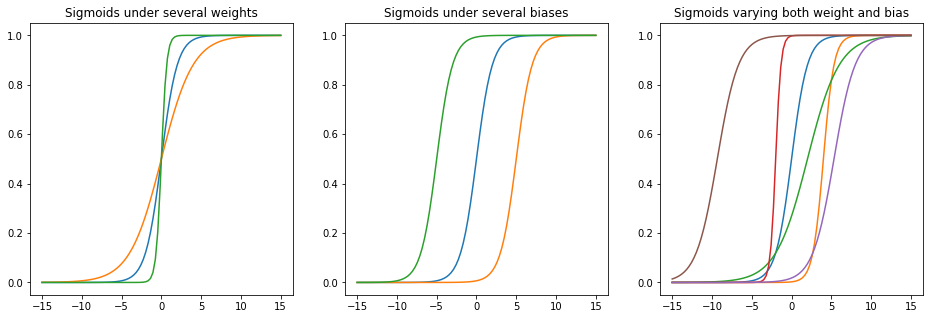

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(x, weight=1, bias=0):
    return 1/(1+np.exp(-1 * (x * weight + bias)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
x = np.linspace(-15, 15, 100)
ax1.plot(x, sigmoid(x), x, sigmoid(x, 0.5), x, sigmoid(x, 3.0))
ax1.set_title("Sigmoids under several weights")
ax2.plot(x, sigmoid(x), x, sigmoid(x, bias=-5), x, sigmoid(x, bias=5))
ax2.set_title("Sigmoids under several biases")
ax3.plot(x, sigmoid(x),
         x, sigmoid(x, 1.5, -6), 
         x, sigmoid(x, 0.5, -1), 
         x, sigmoid(x, 3, 6),
         x, sigmoid(x, 0.75, -4),
         x, sigmoid(x, 0.75, 7))
ax3.set_title("Sigmoids varying both weight and bias");

## Using GPUs with `torch.cuda`

Targetting CUDA GPUs is almost trivial under torch.  The only change we need to make is indicating where the tensors live, and the rest of the code works just the same.  Well, at first brush.  Using multiple GPUs or manual memory management of GPUs, or other lower level concerns, require additional work.  But the easy thing is easy, and is likely to speed up fitting considerably.

In [17]:
%%time
# For demonstration, we can use CPU target if CUDA not available
device = torch.device('cpu')
# Uncomment this to run on GPU
device = torch.device('cuda:0') 

x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Could use any of the versions shown, but for example:
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-4
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        ).to(device)

for t in range(501):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    model.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.data -= learning_rate * param.grad
        
print("Loss after training:", loss.item())

Loss after training: 7.895790986367501e-06
CPU times: user 372 ms, sys: 103 ms, total: 476 ms
Wall time: 513 ms


## Parallelizing on clusters with `torch.distributed`

We cannot get into details in this course, but PyTorch includes capabilities to distribute training over a variety of different architectures, including multiple CPUs or multiple GPUs, including on clusters of machines.

The tutorial at [Writing Distributed Applications with PyTorch](https://pytorch.org/tutorials/intermediate/dist_tuto.html) is a good place to get started.

## Next Lesson

**Tasks with Networks**: We just looked at building a few simple networks, in several styles, using PyTorch.  The new lesson delves into more complex and real world examples.

<a href="NetworkExamples_0.ipynb"><img src="img/open-notebook.png" align="left"/></a>